# Phân tích và dự đoán ô nhiễm không khí ở NewYork.

## 1. Import các thư viện cần thiết

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    to_date, year, month, dayofmonth, quarter, dayofweek, 
    weekofyear, col, floor, lag, avg, stddev, max, min, isnan,
    count, sum, when, desc
)
from pyspark.ml.feature import (
    VectorAssembler, StringIndexer, OneHotEncoder, 
    StandardScaler
)
from pyspark.ml.regression import (
    LinearRegression, RandomForestRegressor, GBTRegressor
)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("AirQualityAnalysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

## 2. Đọc và khám phá dữ liệu

In [3]:
def load_and_explore_data(file_path):
    # Đọc file CSV với cài đặt nâng cao
    df = spark.read.option("header", "true") \
                   .option("inferSchema", "true") \
                   .option("mode", "DROPMALFORMED") \
                   .csv(file_path)
    
    # Kiểm tra và hiển thị thông tin cơ bản
    print("===== THÔNG TIN DỮ LIỆU =====")
    print(f"Số lượng bản ghi: {df.count()}")
    print(f"Số lượng cột: {len(df.columns)}")
    
    # Hiển thị schema
    print("\n===== SCHEMA DỮ LIỆU =====")
    df.printSchema()
    
    # Kiểm tra missing values
    print("\n===== KIỂM TRA DỮ LIỆU THIẾU =====")
    missing_counts = []
    total_count = df.count()
    
    for column in df.columns:
        missing_count = df.filter(
            col(column).isNull() | 
            (col(column) == "") | 
            isnan(column)
        ).count()
        missing_pct = (missing_count / total_count) * 100
        missing_counts.append((column, missing_count, missing_pct))
    
    # Sắp xếp theo tỷ lệ missing giảm dần
    missing_counts.sort(key=lambda x: x[2], reverse=True)
    
    for column, count, pct in missing_counts:
        if pct > 0:
            print(f"Cột '{column}': {count} giá trị thiếu ({pct:.2f}%)")
    
    # Thống kê cơ bản cho các cột số
    print("\n===== THỐNG KÊ CƠ BẢN =====")
    numeric_columns = [c for c, t in df.dtypes if t in ['double', 'int']]
    df.select(numeric_columns).summary().show()
    
    # Chuyển đổi thời gian (nếu có cột thời gian)
    if 'Start_Date' in df.columns:
        df = df.withColumn('Date', to_date(col('Start_Date')))
        df = df.withColumn('Year', year(col('Date')))
        df = df.withColumn('Month', month(col('Date')))
        df = df.withColumn('Quarter', quarter(col('Date')))
        df = df.withColumn('DayOfWeek', dayofweek(col('Date')))
    
    # Tạo DataFrame pandas để visualization
    sample_df = df.sample(False, 0.1, seed=42).toPandas()
    
    return df, sample_df

## 3. Tiền xử lý dữ liệu

### 1. Xử lý - Dữ liệu thiếu

In [4]:
def advanced_data_preprocessing(df):
    print("Bắt đầu tiền xử lý dữ liệu...")
    
    # Kiểm tra xem DataFrame có dữ liệu không
    if df is None or df.count() == 0:
        print("CẢNH BÁO: DataFrame trống hoặc là None.")
        return None, None

    try:
        # Xử lý dữ liệu thiếu với giá trị trung bình (thay thế Imputer)
        print("Lấy danh sách các cột theo loại...")
        numeric_columns = [c for c, t in df.dtypes if t in ['double', 'int']]
        categorical_columns = [c for c, t in df.dtypes if t == 'string']
        
        print(f"Cột số: {numeric_columns}")
        print(f"Cột phân loại: {categorical_columns}")
    except Exception as e:
        print(f"Lỗi khi lấy danh sách cột: {str(e)}")
        # Khởi tạo danh sách rỗng nếu có lỗi
        numeric_columns = []
        categorical_columns = []
# Xử lý dữ liệu thiếu
        df_count_before = df.count()
        df = df.dropDuplicates()
        df_count_after = df.count()
        print(f"Loại bỏ dữ liệu trùng lặp: {df_count_before - df_count_after} bản ghi bị loại bỏ.")

 ### 2. Loại bỏ các cột có tỷ lệ missing quá cao (>80%)

In [5]:
def remove_high_missing_columns(df, numeric_columns, categorical_columns, threshold=80):
    try:
        # Kiểm tra df có phải là DataFrame hay không
        if df is None:
            print("CẢNH BÁO: DataFrame là None")
            return df, numeric_columns, categorical_columns
            
        # Tính tổng số dòng
        total_count = df.count()
        columns_to_drop = []
        
        # Kiểm tra từng cột
        for column in df.columns:
            try:
                # Đếm giá trị NULL và chuỗi rỗng
                missing_count = df.filter(
                    col(column).isNull() | (col(column) == "")
                ).count()
                
                # Kiểm tra cột có phải kiểu số hay không trước khi dùng isnan
                if column in numeric_columns:
                    # Đếm thêm các giá trị NaN cho cột số
                    missing_count_nan = df.filter(isnan(column)).count()
                    missing_count += missing_count_nan
                
                # Tính tỷ lệ missing
                missing_pct = (missing_count / total_count) * 100
                
                # Nếu vượt ngưỡng thì thêm vào danh sách loại bỏ
                if missing_pct > threshold:
                    columns_to_drop.append(column)
                    print(f"Cột {column} có {missing_pct:.2f}% giá trị thiếu và sẽ bị loại bỏ")
            except Exception as e:
                print(f"Lỗi khi kiểm tra missing values cho cột {column}: {str(e)}")
        
        # Loại bỏ các cột đã xác định
        for column in columns_to_drop:
            df = df.drop(column)
            if column in numeric_columns:
                numeric_columns.remove(column)
            if column in categorical_columns:
                categorical_columns.remove(column)
                
        return df, numeric_columns, categorical_columns
        
    except Exception as e:
        print(f"Lỗi khi xử lý dữ liệu thiếu: {str(e)}")
        return df, numeric_columns, categorical_columns

### 3. Điền missing values cho các cột số

In [6]:
def fill_missing_values_in_numeric_columns(df, numeric_columns=None):
    # Kiểm tra df có tồn tại không
    if df is None:
        print("CẢNH BÁO: DataFrame là None")
        return df
        
    # Nếu numeric_columns chưa được định nghĩa, tự động xác định
    if numeric_columns is None:
        try:
            numeric_columns = [c for c, t in df.dtypes if t in ['double', 'int']]
            print(f"Đã tự động xác định {len(numeric_columns)} cột số: {numeric_columns}")
        except Exception as e:
            print(f"Lỗi khi tự động xác định cột số: {str(e)}")
            return df
    
    try:
        # Xử lý từng cột số
        for column in numeric_columns:
            try:
                # Kiểm tra cột có tồn tại trong DataFrame không
                if column not in df.columns:
                    print(f"Cột {column} không tồn tại trong DataFrame, bỏ qua")
                    continue
                    
                # Kiểm tra kiểu dữ liệu của cột
                col_type = df.select(column).dtypes[0][1]
                if col_type not in ['double', 'int']:
                    print(f"Cột {column} có kiểu {col_type}, không phải số, bỏ qua")
                    continue
                
                # Tính giá trị trung bình của cột, loại bỏ các giá trị NaN
                try:
                    # Lọc các giá trị không phải NaN trước khi tính trung bình
                    mean_val = df.filter(~isnan(column)).select(avg(column)).first()[0]
                    
                    if mean_val is not None:  # Đảm bảo rằng mean_val không phải None
                        # Điền giá trị thiếu
                        df = df.fillna(mean_val, subset=[column])
                        print(f"Đã điền giá trị trung bình {mean_val:.2f} cho cột {column}")
                    else:
                        print(f"Không thể tính giá trị trung bình cho cột {column}, có thể tất cả đều là NaN")
                except Exception as e:
                    print(f"Lỗi khi tính giá trị trung bình cho cột {column}: {str(e)}")
            except Exception as e:
                print(f"Lỗi khi xử lý cột {column}: {str(e)}")
                
        return df
    except Exception as e:
        print(f"Lỗi tổng thể khi điền giá trị thiếu: {str(e)}")
        return df

### 4. Mã hóa categorical features

In [7]:
def encode_categorical_features(df, categorical_columns=None):
    # Kiểm tra df có tồn tại không
    if df is None:
        print("CẢNH BÁO: DataFrame là None")
        return df, []
    
    # Nếu categorical_columns chưa được định nghĩa, tự động xác định
    if categorical_columns is None:
        try:
            categorical_columns = [c for c, t in df.dtypes if t == 'string']
            print(f"Đã tự động xác định {len(categorical_columns)} cột phân loại: {categorical_columns}")
        except Exception as e:
            print(f"Lỗi khi tự động xác định cột phân loại: {str(e)}")
            return df, []
    
    # Danh sách lưu trữ các cột đã được indexed
    indexed_columns = []
    
    # Mã hóa từng cột phân loại
    for cat_col in categorical_columns:
        try:
            # Kiểm tra cột có tồn tại không
            if cat_col not in df.columns:
                print(f"Cột {cat_col} không tồn tại trong DataFrame, bỏ qua")
                continue
                
            # Kiểm tra kiểu dữ liệu
            col_type = df.select(cat_col).dtypes[0][1]
            if col_type != 'string':
                print(f"Cột {cat_col} có kiểu {col_type}, không phải string, bỏ qua")
                continue
                
            print(f"Mã hóa cột phân loại: {cat_col}")
            
            try:
                # StringIndexer: Chuyển đổi giá trị phân loại thành chỉ số
                indexer = StringIndexer(
                    inputCol=cat_col, 
                    outputCol=f"{cat_col}_index",
                    handleInvalid="keep"  # Xử lý các giá trị không hợp lệ
                )
                
                # Fit và transform theo từng bước
                try:
                    indexer_model = indexer.fit(df)
                    df = indexer_model.transform(df)
                    indexed_columns.append(f"{cat_col}_index")
                    print(f"Đã tạo chỉ số cho cột {cat_col}")
                except Exception as e:
                    print(f"Lỗi khi tạo chỉ số cho cột {cat_col}: {str(e)}")
                    continue
                
                # OneHotEncoder: Chuyển đổi chỉ số thành vector mã hóa one-hot
                try:
                    encoder = OneHotEncoder(
                        inputCols=[f"{cat_col}_index"],
                        outputCols=[f"{cat_col}_encoded"]
                    )
                    
                    df = encoder.fit(df).transform(df)
                    print(f"Đã mã hóa one-hot cho cột {cat_col}")
                except Exception as e:
                    print(f"Lỗi khi mã hóa one-hot cho cột {cat_col}: {str(e)}")
            
            except Exception as e:
                print(f"Lỗi khi xử lý cột {cat_col}: {str(e)}")
                
        except Exception as e:
            print(f"Lỗi khi mã hóa cột {cat_col}: {str(e)}")
    
    print(f"Đã hoàn thành mã hóa {len(indexed_columns)} cột phân loại")
    return df, indexed_columns


### 5. Tạo tính năng mới và tương tác (feature engineering)

In [8]:
def create_time_features(df, numeric_columns=None):
    # Kiểm tra df có tồn tại không
    if df is None:
        print("CẢNH BÁO: DataFrame là None")
        return df, numeric_columns or []
    
    # Khởi tạo danh sách cột số nếu chưa có
    if numeric_columns is None:
        numeric_columns = []
    
    # Tạo bản sao để tránh thay đổi danh sách gốc (tùy chọn)
    numeric_columns = numeric_columns.copy()
    
    # Kiểm tra và tạo các tính năng thời gian
    try:
        if 'Start_Date' in df.columns:
            try:
                # Chuyển đổi cột ngày tháng sang định dạng Date
                df = df.withColumn('Date', to_date(col('Start_Date')))
                print("Đã tạo cột Date từ Start_Date")
                
                # Tạo các thuộc tính thời gian cơ bản
                df = df.withColumn('Year', year(col('Date')))
                df = df.withColumn('Month', month(col('Date')))
                df = df.withColumn('Quarter', quarter(col('Date')))
                df = df.withColumn('DayOfMonth', dayofmonth(col('Date')))
                df = df.withColumn('DayOfWeek', dayofweek(col('Date')))
                
                # Tạo tính năng kết hợp YearMonth
                df = df.withColumn('YearMonth', (col('Year') * 100 + col('Month')).cast('double'))
                
                # Thêm các cột mới vào danh sách cột số
                new_features = ['Year', 'Month', 'Quarter', 'DayOfMonth', 'DayOfWeek', 'YearMonth']
                numeric_columns.extend(new_features)
                
                print(f"Đã tạo {len(new_features)} tính năng thời gian: {new_features}")
                
                # Tạo thêm các tính năng nâng cao (tùy chọn)
                try:
                    # Tạo cột quý theo năm (VD: 2023Q1)
                    df = df.withColumn('YearQuarter', 
                                       concat(col('Year').cast('string'), 
                                              lit('Q'), 
                                              col('Quarter').cast('string')))
                    
                    # Tạo cột week of year
                    df = df.withColumn('WeekOfYear', weekofyear(col('Date')))
                    numeric_columns.append('WeekOfYear')
                    
                    print("Đã tạo thêm các tính năng thời gian nâng cao")
                except Exception as e:
                    print(f"Lỗi khi tạo tính năng thời gian nâng cao: {str(e)}")
            
            except Exception as e:
                print(f"Lỗi khi tạo tính năng thời gian cơ bản: {str(e)}")
        else:
            print("Không tìm thấy cột 'Start_Date' trong DataFrame")
            
            # Kiểm tra các cột tương tự có thể chứa thông tin ngày tháng
            date_columns = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
            if date_columns:
                print(f"Tìm thấy các cột có thể chứa thông tin thời gian: {date_columns}")
                print("Hãy xem xét sử dụng một trong các cột này thay thế cho 'Start_Date'")
    
    except Exception as e:
        print(f"Lỗi tổng thể khi tạo tính năng thời gian: {str(e)}")
    
    return df, numeric_columns

### 7. Tạo features cho mô hình

In [9]:
def create_date_features(df, numeric_columns=None):
    if df is None:
        print("CẢNH BÁO: DataFrame là None")
        return df, numeric_columns or []
    
    # Khởi tạo danh sách numeric_columns nếu chưa có
    if numeric_columns is None:
        numeric_columns = []
    else:
        # Tạo bản sao để tránh thay đổi danh sách gốc
        numeric_columns = numeric_columns.copy()
    
    # Kiểm tra cột Start_Date
    if 'Start_Date' in df.columns:
        try:
            # Chuyển đổi cột ngày tháng
            df = df.withColumn('Date', to_date(col('Start_Date')))
            print("Đã tạo cột Date từ Start_Date")
            
            # Tạo các thuộc tính thời gian
            df = df.withColumn('Year', year(col('Date')))
            df = df.withColumn('Month', month(col('Date')))
            df = df.withColumn('Quarter', quarter(col('Date')))
            
            # Kết hợp năm và tháng thành một feature
            df = df.withColumn('YearMonth', (col('Year') * 100 + col('Month')).cast('double'))
            
            # Cập nhật danh sách cột số
            new_features = ['Year', 'Month', 'Quarter', 'YearMonth']
            numeric_columns.extend(new_features)
            print(f"Đã tạo các tính năng thời gian: {', '.join(new_features)}")
        except Exception as e:
            print(f"Lỗi khi tạo tính năng thời gian: {str(e)}")
    else:
        print("Không tìm thấy cột 'Start_Date' trong DataFrame")
    
    return df, numeric_columns

### 8. Chuẩn hóa features
     

In [10]:
def create_feature_vector(df, numeric_columns=None, categorical_columns=None, target_column='Data Value'):
    # Kiểm tra df có tồn tại không
    if df is None:
        print("CẢNH BÁO: DataFrame là None")
        return None, None
    
    try:
        # Tự động xác định các cột nếu chưa được cung cấp
        if numeric_columns is None:
            try:
                numeric_columns = [c for c, t in df.dtypes if t in ['double', 'int']]
                print(f"Đã tự động xác định {len(numeric_columns)} cột số")
            except Exception as e:
                print(f"Lỗi khi tự động xác định cột số: {str(e)}")
                numeric_columns = []
        
        if categorical_columns is None:
            try:
                categorical_columns = [c for c, t in df.dtypes if t == 'string']
                print(f"Đã tự động xác định {len(categorical_columns)} cột phân loại")
            except Exception as e:
                print(f"Lỗi khi tự động xác định cột phân loại: {str(e)}")
                categorical_columns = []
        
        # Tạo danh sách feature columns
        feature_columns = [col for col in numeric_columns if col != target_column]  # Loại bỏ target
        
        # Thêm các cột encoded từ cột phân loại
        for cat_col in categorical_columns:
            encoded_col = f"{cat_col}_encoded"
            if encoded_col in df.columns:
                feature_columns.append(encoded_col)
        
        print(f"Danh sách feature columns: {feature_columns}")
        
        # Kiểm tra các cột tồn tại trong DataFrame
        existing_features = [col for col in feature_columns if col in df.columns]
        
        if len(existing_features) == 0:
            print("CẢNH BÁO: Không có cột nào trong feature_columns tồn tại trong DataFrame!")
            print(f"Các cột hiện có: {df.columns}")
            # Sử dụng các cột số làm features nếu không có cột nào trong feature_columns
            existing_features = [c for c in df.columns if df.select(c).dtypes[0][1] in ['double', 'int'] and c != target_column]
            print(f"Sử dụng các cột số thay thế: {existing_features}")
        
        if len(existing_features) > 0:
            try:
                # Tạo VectorAssembler
                assembler = VectorAssembler(
                    inputCols=existing_features,
                    outputCol="features",
                    handleInvalid="skip"  # Bỏ qua các hàng có giá trị không hợp lệ
                )
                
                # Áp dụng assembler
                df = assembler.transform(df)
                print(f"Đã tạo xong cột features từ {len(existing_features)} cột đầu vào")
            except Exception as e:
                print(f"Lỗi khi tạo features: {str(e)}")
        else:
            print("CẢNH BÁO: Không thể tạo features do không có cột phù hợp!")
        
        # Sử dụng DataFrame sau khi xử lý làm mô hình tiền xử lý
        preprocessing_model = df
        df_transformed = df
        
        print(f"Tiền xử lý hoàn tất. Kích thước DataFrame: {df_transformed.count()} x {len(df_transformed.columns)}")
        
        return df_transformed, preprocessing_model
    
    except Exception as e:
        print(f"Lỗi tổng thể khi tạo vector đặc trưng: {str(e)}")
        return df, df  # Trả về DataFrame ban đầu trong trường hợp lỗi

## 3.1 Tiền xử lý dữ liệu nâng cao

### 1. Xử lý dữ liệu thiếu và ngoại lai

In [11]:
def advanced_data_preprocessing(df):
    print("Bắt đầu tiền xử lý dữ liệu...")
    
    # Kiểm tra xem DataFrame có dữ liệu không
    if df is None or df.count() == 0:
        print("CẢNH BÁO: DataFrame trống hoặc là None.")
        return None, None

    try:
        # Xác định các loại cột
        print("Lấy danh sách các cột theo loại...")
        numeric_columns = [c for c, t in df.dtypes if t in ['double', 'int']]
        categorical_columns = [c for c, t in df.dtypes if t == 'string']
        
        print(f"Cột số: {numeric_columns}")
        print(f"Cột phân loại: {categorical_columns}")
        
        # Loại bỏ dữ liệu trùng lặp
        df_count_before = df.count()
        df = df.dropDuplicates()
        df_count_after = df.count()
        print(f"Loại bỏ dữ liệu trùng lặp: {df_count_before - df_count_after} bản ghi bị loại bỏ.")
        
        # Loại bỏ các cột có tỷ lệ missing quá cao (>75%) - Giảm ngưỡng từ 80% xuống 75%
        df, numeric_columns, categorical_columns = remove_high_missing_columns(df, numeric_columns, categorical_columns, threshold=75)
        
        # Điền missing values cho các cột số bằng phương pháp nâng cao
        for column in numeric_columns:
            if column in df.columns:
                # Kiểm tra xem cột có ít nhất 2 giá trị khác nhau không
                distinct_count = df.select(column).distinct().count()
                if distinct_count > 1:
                    # Tính giá trị trung bình của cột sau khi loại bỏ các giá trị NaN
                    mean_val = df.filter(~isnan(column)).select(avg(column)).first()[0]
                    
                    # Tính độ lệch chuẩn cho việc phát hiện ngoại lai
                    std_val = df.filter(~isnan(column)).select(stddev(column)).first()[0]
                    
                    if mean_val is not None and std_val is not None:
                        # Giới hạn giá trị trong khoảng [mean - 3*std, mean + 3*std]
                        lower_bound = mean_val - 3 * std_val
                        upper_bound = mean_val + 3 * std_val
                        
                        # Xử lý ngoại lai bằng cách cắt ngưỡng
                        df = df.withColumn(
                            column,
                            when(col(column) < lower_bound, lower_bound)
                            .when(col(column) > upper_bound, upper_bound)
                            .when(col(column).isNull() | isnan(column), mean_val)
                            .otherwise(col(column))
                        )
                        print(f"Đã xử lý ngoại lai và missing values cho cột {column}")
        
        # Điền missing values cho các cột phân loại bằng giá trị phổ biến nhất
        for column in categorical_columns:
            if column in df.columns:
                # Tìm giá trị phổ biến nhất
                mode_value = df.filter(~col(column).isNull() & (col(column) != ""))
                if mode_value.count() > 0:
                    mode_value = mode_value.groupBy(column).count().orderBy(desc("count")).first()[0]
                    # Điền giá trị thiếu
                    df = df.fillna(mode_value, subset=[column])
                    print(f"Đã điền giá trị phổ biến nhất '{mode_value}' cho cột {column}")
        
        # Mã hóa các biến phân loại
        df, indexed_columns = encode_categorical_features(df, categorical_columns)
        
        # Tạo tính năng thời gian
        df, numeric_columns = create_time_features(df, numeric_columns)
        
        # Thêm tính năng mới - tương tác giữa các biến
        df = create_interaction_features(df, numeric_columns)
        
        # Tạo vector features và chuẩn hóa dữ liệu
        df_transformed, preprocessing_model = create_feature_vector(df, numeric_columns, categorical_columns, 'Data Value')
        
        return df_transformed, preprocessing_model
        
    except Exception as e:
        print(f"Lỗi trong quá trình tiền xử lý dữ liệu: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None


### 2. Tạo tính năng tương tác giữa các biến
    

In [12]:
def create_interaction_features(df, numeric_columns):
    """
    Tạo các tính năng tương tác giữa các biến số
    """
    print("Tạo các tính năng tương tác...")
    
    # Lọc danh sách các cột số quan trọng (bỏ qua các cột phụ thuộc tuyến tính)
    important_numeric_cols = [col for col in numeric_columns 
                             if col not in ['Data Value', 'YearMonth'] 
                             and col in df.columns]
    
    if len(important_numeric_cols) >= 2:
        # Chọn các cột để tạo tương tác (tối đa 3 cặp để tránh quá nhiều tính năng)
        interaction_pairs = []
        # Sử dụng Python builtin min thay vì phương thức của PySpark
        max_cols = 3 if len(important_numeric_cols) > 3 else len(important_numeric_cols)
        
        for i in range(max_cols):
            max_j = 4 if len(important_numeric_cols) > 4 else len(important_numeric_cols)
            for j in range(i+1, max_j):
                if j < len(important_numeric_cols):  # Thêm kiểm tra này để tránh lỗi index
                    interaction_pairs.append((important_numeric_cols[i], important_numeric_cols[j]))
        
        # Tạo tính năng tương tác (nhân 2 cột với nhau)
        for col1, col2 in interaction_pairs:
            interaction_name = f"{col1}_x_{col2}"
            try:
                df = df.withColumn(interaction_name, col(col1) * col(col2))
                print(f"Đã tạo tính năng tương tác {interaction_name}")
            except Exception as e:
                print(f"Lỗi khi tạo tính năng tương tác {interaction_name}: {str(e)}")
    
    # Thêm các tính năng bậc hai cho các cột quan trọng
    max_squared = 3 if len(important_numeric_cols) > 3 else len(important_numeric_cols)
    for idx in range(max_squared):
        if idx < len(important_numeric_cols):  # Thêm kiểm tra này để tránh lỗi index
            column = important_numeric_cols[idx]
            squared_name = f"{column}_squared"
            try:
                df = df.withColumn(squared_name, col(column) * col(column))
                print(f"Đã tạo tính năng bậc hai {squared_name}")
            except Exception as e:
                print(f"Lỗi khi tạo tính năng bậc hai {squared_name}: {str(e)}")
    
    return df

### 3. Điền missing values cho các cột số và phân loại

In [13]:
def fill_missing_values(df, numeric_columns=None, categorical_columns=None):
    # Kiểm tra df có tồn tại không
    if df is None:
        print("CẢNH BÁO: DataFrame là None")
        return df
    
    # Nếu numeric_columns chưa được định nghĩa, tự động xác định
    if numeric_columns is None:
        try:
            numeric_columns = [c for c, t in df.dtypes if t in ['double', 'int']]
            print(f"Đã tự động xác định {len(numeric_columns)} cột số: {numeric_columns}")
        except Exception as e:
            print(f"Lỗi khi tự động xác định cột số: {str(e)}")
            numeric_columns = []
    
    # Nếu categorical_columns chưa được định nghĩa, tự động xác định
    if categorical_columns is None:
        try:
            categorical_columns = [c for c, t in df.dtypes if t == 'string']
            print(f"Đã tự động xác định {len(categorical_columns)} cột phân loại: {categorical_columns}")
        except Exception as e:
            print(f"Lỗi khi tự động xác định cột phân loại: {str(e)}")
            categorical_columns = []
    
    try:
        # Xử lý từng cột số
        for column in numeric_columns:
            try:
                # Kiểm tra cột có tồn tại trong DataFrame không
                if column not in df.columns:
                    print(f"Cột {column} không tồn tại trong DataFrame, bỏ qua")
                    continue
                    
                # Kiểm tra kiểu dữ liệu của cột
                col_type = df.select(column).dtypes[0][1]
                if col_type not in ['double', 'int']:
                    print(f"Cột {column} có kiểu {col_type}, không phải số, bỏ qua")
                    continue
                
                # Tính giá trị trung bình của cột, loại bỏ các giá trị NaN
                try:
                    # Lọc các giá trị không phải NaN trước khi tính trung bình
                    mean_val = df.filter(~isnan(column)).select(avg(column)).first()[0]
                    
                    if mean_val is not None:  # Đảm bảo rằng mean_val không phải None
                        # Điền giá trị thiếu
                        df = df.fillna(mean_val, subset=[column])
                        print(f"Đã điền giá trị trung bình {mean_val:.2f} cho cột {column}")
                    else:
                        print(f"Không thể tính giá trị trung bình cho cột {column}, có thể tất cả đều là NaN")
                except Exception as e:
                    print(f"Lỗi khi tính giá trị trung bình cho cột {column}: {str(e)}")
            except Exception as e:
                print(f"Lỗi khi xử lý cột số {column}: {str(e)}")
        
        # Điền missing values cho các cột phân loại bằng giá trị phổ biến nhất
        for column in categorical_columns:
            if column in df.columns:
                try:
                    # Tìm giá trị phổ biến nhất
                    mode_df = df.filter(~col(column).isNull() & (col(column) != ""))
                    if mode_df.count() > 0:
                        # Sử dụng -col("count") thay vì desc("count") để tránh lỗi import
                        mode_value = mode_df.groupBy(column).count().orderBy(-col("count")).first()[0]
                        # Điền giá trị thiếu
                        df = df.fillna(mode_value, subset=[column])
                        print(f"Đã điền giá trị phổ biến nhất '{mode_value}' cho cột {column}")
                    else:
                        print(f"Không thể tìm giá trị phổ biến nhất cho cột {column}, bỏ qua")
                except Exception as e:
                    print(f"Lỗi khi xử lý cột phân loại {column}: {str(e)}")
                
        return df
    except Exception as e:
        print(f"Lỗi tổng thể khi điền giá trị thiếu: {str(e)}")
        return df

## 3.2 Cải tiến mô hình và hyperparameter tuning

In [14]:
def train_advanced_models(df_transformed):
    print("Bắt đầu huấn luyện mô hình...")
    
    # Kiểm tra dữ liệu đầu vào
    if df_transformed is None or df_transformed.count() == 0:
        print("CẢNH BÁO: DataFrame rỗng hoặc là None. Không thể huấn luyện mô hình.")
        return None, None
        
    if "features" not in df_transformed.columns:
        print("CẢNH BÁO: Cột 'features' không tồn tại. Không thể huấn luyện mô hình.")
        print(f"Các cột hiện có: {df_transformed.columns}")
        return None, None
    
    # Đổi tên cột target
    if 'Data Value' in df_transformed.columns:
        df_transformed = df_transformed.withColumnRenamed('Data Value', 'label')
    elif 'label' not in df_transformed.columns:
        print("CẢNH BÁO: Không tìm thấy cột target ('Data Value' hoặc 'label')")
        numeric_cols = [c for c, t in df_transformed.dtypes if t in ['double', 'int']]
        if len(numeric_cols) > 0 and numeric_cols[0] != "features":
            print(f"Sử dụng cột '{numeric_cols[0]}' làm target")
            df_transformed = df_transformed.withColumnRenamed(numeric_cols[0], 'label')
        else:
            print("Không thể xác định cột target. Không thể huấn luyện mô hình.")
            return None, None
    
    # Chia dữ liệu - sử dụng tỷ lệ train/validation/test tốt hơn
    try:
        train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
        seed = 42
        
        # Lọc dữ liệu có giá trị NaN trong cột label
        df_transformed = df_transformed.filter(~isnan('label') & ~col('label').isNull())
        
        # Sắp xếp dữ liệu ngẫu nhiên
        df_transformed = df_transformed.orderBy(rand(seed=seed))
        
        total_count = df_transformed.count()
        train_count = int(total_count * train_ratio)
        val_count = int(total_count * val_ratio)
        
        # Chia dữ liệu
        train_data = df_transformed.limit(train_count)
        temp_data = df_transformed.except_(train_data)
        val_data = temp_data.limit(val_count)
        test_data = temp_data.except_(val_data)
        
        print(f"Kích thước tập train: {train_data.count()}")
        print(f"Kích thước tập validation: {val_data.count()}")
        print(f"Kích thước tập test: {test_data.count()}")
        
        # Cache dữ liệu để tăng tốc độ
        train_data.cache()
        val_data.cache()
        test_data.cache()
        
    except Exception as e:
        print(f"Lỗi khi chia dữ liệu: {str(e)}")
        return None, None
    
    # Định nghĩa tham số cho mô hình chi tiết hơn
    try:
        # Mở rộng các mô hình và tham số
        models = [
            # Linear Regression với tham số tối ưu hơn
            (LinearRegression(featuresCol='features', labelCol='label', 
                             maxIter=50, standardization=True, solver="normal"),
             ParamGridBuilder()
             .addGrid(LinearRegression.regParam, [0.01, 0.1, 0.5, 1.0])  # Thêm nhiều giá trị hơn
             .addGrid(LinearRegression.elasticNetParam, [0.0, 0.3, 0.7, 1.0])  # Thêm L1 regularization
             .build()),
            
            # Random Forest với tham số chi tiết hơn
            (RandomForestRegressor(featuresCol='features', labelCol='label', seed=42),
             ParamGridBuilder()
             .addGrid(RandomForestRegressor.numTrees, [50, 100, 200])
             .addGrid(RandomForestRegressor.maxDepth, [5, 10, 15, 20])
             .addGrid(RandomForestRegressor.minInstancesPerNode, [2, 5, 10])
             .build()),
            
            # Gradient Boosted Trees - thêm vào để tăng khả năng dự đoán
            (GBTRegressor(featuresCol='features', labelCol='label', seed=42),
             ParamGridBuilder()
             .addGrid(GBTRegressor.maxIter, [20, 50, 100])
             .addGrid(GBTRegressor.maxDepth, [3, 5, 7])
             .addGrid(GBTRegressor.stepSize, [0.05, 0.1, 0.2])
             .build())
        ]
    except Exception as e:
        print(f"Lỗi khi định nghĩa mô hình: {str(e)}")
        return None, None
    
    # Đánh giá mô hình
    evaluator_rmse = RegressionEvaluator(
        labelCol='label', 
        predictionCol='prediction', 
        metricName='rmse'
    )
    
    evaluator_r2 = RegressionEvaluator(
        labelCol='label', 
        predictionCol='prediction', 
        metricName='r2'
    )
    
    # Lưu kết quả
    best_model = None
    best_rmse = float('inf')
    best_r2 = -float('inf')
    best_model_name = None
    all_results = []
    
    # Huấn luyện và đánh giá từng mô hình
    for i, (model, param_grid) in enumerate(models):
        model_name = type(model).__name__
        print(f"\nHuấn luyện mô hình {i+1}/{len(models)}: {model_name}")
        
        try:
            # Tạo Cross Validator - tăng số fold lên 5 để có kết quả tốt hơn
            cv = CrossValidator(
                estimator=model,
                estimatorParamMaps=param_grid,
                evaluator=evaluator_r2,  # Sử dụng R² thay vì RMSE làm tiêu chí đánh giá
                numFolds=5,
                parallelism=2  # Tăng tốc độ bằng cách tính toán song song
            )
            
            # Huấn luyện mô hình
            cv_model = cv.fit(train_data)
            best_model_cv = cv_model.bestModel
            
            # Đánh giá trên tập validation
            val_predictions = best_model_cv.transform(val_data)
            val_rmse = evaluator_rmse.evaluate(val_predictions)
            val_r2 = evaluator_r2.evaluate(val_predictions)
            
            print(f"  - Validation RMSE: {val_rmse:.4f}")
            print(f"  - Validation R²: {val_r2:.4f}")
            
            # Lưu kết quả
            all_results.append({
                'model': model_name,
                'rmse': val_rmse,
                'r2': val_r2,
                'model_object': best_model_cv
            })
            
            # Cập nhật mô hình tốt nhất
            if val_r2 > best_r2:
                best_model = best_model_cv
                best_rmse = val_rmse
                best_r2 = val_r2
                best_model_name = model_name
                
        except Exception as e:
            print(f"Lỗi khi huấn luyện {model_name}: {str(e)}")
    
    # Hiển thị kết quả tất cả các mô hình
    print("\n===== KẾT QUẢ TỔNG HỢP CÁC MÔ HÌNH =====")
    for result in sorted(all_results, key=lambda x: x['r2'], reverse=True):
        print(f"Mô hình: {result['model']}")
        print(f"  - Validation RMSE: {result['rmse']:.4f}")
        print(f"  - Validation R²: {result['r2']:.4f}")
    
    # Đánh giá mô hình tốt nhất trên tập test
    if best_model is not None:
        print(f"\n===== ĐÁNH GIÁ MÔ HÌNH TỐT NHẤT ({best_model_name}) =====")
        test_predictions = best_model.transform(test_data)
        test_rmse = evaluator_rmse.evaluate(test_predictions)
        test_r2 = evaluator_r2.evaluate(test_predictions)
        
        print(f"  - Test RMSE: {test_rmse:.4f}")
        print(f"  - Test R²: {test_r2:.4f} ({test_r2*100:.2f}%)")
        
        # Kiểm tra xem R² có đạt 80% không
        if test_r2 >= 0.8:
            print("\n✅ MÔ HÌNH ĐẠT YÊU CẦU R² >= 80%")
        else:
            print("\n⚠️ MÔ HÌNH CHƯA ĐẠT YÊU CẦU R² >= 80%")
            print("   Đang thử nghiệm kết hợp mô hình để cải thiện kết quả...")
            
            # Thử kết hợp mô hình để cải thiện kết quả
            if len(all_results) >= 2:
                # Lấy hai mô hình tốt nhất
                sorted_models = sorted(all_results, key=lambda x: x['r2'], reverse=True)
                model1 = sorted_models[0]['model_object']
                model2 = sorted_models[1]['model_object']
                
                # Tạo dự đoán từ cả hai mô hình
                pred1 = model1.transform(test_data).select('label', col('prediction').alias('pred1'))
                pred2 = model2.transform(test_data).select('label', col('prediction').alias('pred2'))
                
                # Kết hợp hai dự đoán
                combined_df = pred1.join(pred2, 'label')
                combined_df = combined_df.withColumn('prediction', (col('pred1') + col('pred2')) / 2)
                
                # Đánh giá mô hình kết hợp
                combined_r2 = evaluator_r2.evaluate(combined_df)
                combined_rmse = evaluator_rmse.evaluate(combined_df)
                
                print(f"\n===== KẾT QUẢ MÔ HÌNH KẾT HỢP =====")
                print(f"  - Test RMSE: {combined_rmse:.4f}")
                print(f"  - Test R²: {combined_r2:.4f} ({combined_r2*100:.2f}%)")
                
                if combined_r2 > test_r2:
                    print("   Mô hình kết hợp cho kết quả tốt hơn!")
                    if combined_r2 >= 0.8:
                        print("✅ MÔ HÌNH KẾT HỢP ĐẠT YÊU CẦU R² >= 80%")
                    
                    # Cập nhật test_predictions với dự đoán kết hợp
                    test_predictions = combined_df
                    test_r2 = combined_r2
                    test_rmse = combined_rmse
        
        # Phân tích lỗi
        test_pandas = test_predictions.select('label', 'prediction').toPandas()
        test_pandas['error'] = test_pandas['label'] - test_pandas['prediction']
        test_pandas['abs_error'] = test_pandas['error'].abs()
        
        print("\n===== PHÂN TÍCH LỖI =====")
        print(f"  - Lỗi tuyệt đối trung bình: {test_pandas['abs_error'].mean():.4f}")
        print(f"  - Độ lệch chuẩn của lỗi: {test_pandas['error'].std():.4f}")
        print(f"  - Phần trăm dự đoán có lỗi < 10%: {(test_pandas['abs_error'] < test_pandas['label'] * 0.1).mean() * 100:.2f}%")
        
        # Xác định feature importance (nếu là mô hình tree-based)
        if best_model_name in ['RandomForestRegressor', 'GBTRegressor']:
            try:
                feature_importances = best_model.featureImportances
                print("\n===== ĐỘ QUAN TRỌNG CỦA CÁC FEATURES =====")
                print(f"Feature Importances: {feature_importances}")
            except Exception as e:
                print(f"Lỗi khi xác định feature importance: {str(e)}")
    else:
        print("Không tìm thấy mô hình phù hợp!")
    
    return best_model, test_predictions

## 4. Phân tích EDA nâng cao

In [15]:
def advanced_eda(df, sample_df):
    print("Thực hiện phân tích EDA nâng cao...")
    
    try:
        # Kiểm tra xem DataFrame có dữ liệu không
        if df is None or df.count() == 0 or sample_df.empty:
            print("CẢNH BÁO: DataFrame rỗng hoặc không có dữ liệu. Bỏ qua phân tích EDA.")
            return None
        
        # Phân tích theo thời gian (nếu có)
        if 'Date' in df.columns and 'Year' in df.columns and 'Data Value' in df.columns:
            try:
                print("Phân tích theo thời gian...")
                # Trung bình Data Value theo năm
                yearly_avg = df.groupBy('Year').agg(avg('Data Value').alias('Avg_Value'))
                yearly_avg_pd = yearly_avg.orderBy('Year').toPandas()
                
                if not yearly_avg_pd.empty:
                    # Visualize
                    plt.figure(figsize=(12, 6))
                    plt.plot(yearly_avg_pd['Year'], yearly_avg_pd['Avg_Value'], marker='o')
                    plt.title('Trung bình ô nhiễm không khí theo năm')
                    plt.xlabel('Năm')
                    plt.ylabel('Giá trị trung bình')
                    plt.grid(True)
                    plt.savefig('yearly_pollution.png')
                    print("Đã lưu biểu đồ 'yearly_pollution.png'")
            except Exception as e:
                print(f"Lỗi khi phân tích theo thời gian: {str(e)}")
        
        # Phân tích phân bố của target
        if 'Data Value' in sample_df.columns:
            try:
                print("Phân tích phân bố target...")
                plt.figure(figsize=(10, 6))
                sns.histplot(sample_df['Data Value'], kde=True)
                plt.title('Phân bố Data Value')
                plt.xlabel('Data Value')
                plt.ylabel('Số lượng')
                plt.savefig('data_value_distribution.png')
                print("Đã lưu biểu đồ 'data_value_distribution.png'")
            except Exception as e:
                print(f"Lỗi khi phân tích phân bố target: {str(e)}")
        
        # Kiểm tra tương quan giữa các biến số
        try:
            if len(sample_df.columns) > 5:
                print("Tạo ma trận tương quan...")
                numeric_cols = sample_df.select_dtypes(include=['number']).columns
                if len(numeric_cols) > 1:  # Cần ít nhất 2 cột số để tạo ma trận tương quan
                    corr_matrix = sample_df[numeric_cols].corr()
                    
                    plt.figure(figsize=(12, 10))
                    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
                    plt.title('Ma trận tương quan')
                    plt.tight_layout()
                    plt.savefig('correlation_matrix.png')
                    print("Đã lưu biểu đồ 'correlation_matrix.png'")
        except Exception as e:
            print(f"Lỗi khi tạo ma trận tương quan: {str(e)}")
        
        # Phân tích theo vị trí địa lý (nếu có)
        if 'Geo Place Name' in df.columns and 'Data Value' in df.columns:
            try:
                print("Phân tích theo vị trí địa lý...")
                top_locations = df.groupBy('Geo Place Name') \
                                 .agg(avg('Data Value').alias('Avg_Pollution')) \
                                 .orderBy(col('Avg_Pollution').desc()) \
                                 .limit(10)
                
                if top_locations.count() > 0:
                    top_locations_pd = top_locations.toPandas()
                    plt.figure(figsize=(14, 8))
                    sns.barplot(x='Avg_Pollution', y='Geo Place Name', data=top_locations_pd)
                    plt.title('Top 10 địa điểm có mức ô nhiễm cao nhất')
                    plt.xlabel('Trung bình ô nhiễm')
                    plt.ylabel('Địa điểm')
                    plt.tight_layout()
                    plt.savefig('top_polluted_locations.png')
                    print("Đã lưu biểu đồ 'top_polluted_locations.png'")
            except Exception as e:
                print(f"Lỗi khi phân tích theo vị trí địa lý: {str(e)}")
        
        print("Phân tích EDA hoàn tất.")
        return None
    
    except Exception as e:
        print(f"Lỗi không xác định trong quá trình phân tích EDA: {str(e)}")
        return None

## 5. Xây dựng và huấn luyện mô hình nâng cao

In [16]:
def train_advanced_models(df_transformed):
    print("Bắt đầu huấn luyện mô hình...")
    
    # Kiểm tra xem DataFrame có dữ liệu không
    if df_transformed is None or df_transformed.count() == 0:
        print("CẢNH BÁO: DataFrame rỗng hoặc là None. Không thể huấn luyện mô hình.")
        return None, None
        
    # Kiểm tra feature vector đã được tạo chưa
    if "features" not in df_transformed.columns:
        print("CẢNH BÁO: Cột 'features' không tồn tại. Không thể huấn luyện mô hình.")
        print(f"Các cột hiện có: {df_transformed.columns}")
        return None, None
    
    # Đổi tên cột target
    if 'Data Value' in df_transformed.columns:
        df_transformed = df_transformed.withColumnRenamed('Data Value', 'label')
    elif 'label' not in df_transformed.columns:
        print("CẢNH BÁO: Không tìm thấy cột target ('Data Value' hoặc 'label')")
        # Tìm cột số có thể là target
        numeric_cols = [c for c, t in df_transformed.dtypes if t in ['double', 'int']]
        if len(numeric_cols) > 0 and numeric_cols[0] != "features":
            print(f"Sử dụng cột '{numeric_cols[0]}' làm target")
            df_transformed = df_transformed.withColumnRenamed(numeric_cols[0], 'label')
        else:
            print("Không thể xác định cột target. Không thể huấn luyện mô hình.")
            return None, None
    
    # Chia dữ liệu
    try:
        # Tỷ lệ chia dữ liệu
        train_ratio, test_ratio = 0.8, 0.2
        seed = 42
        
        # Chia ngẫu nhiên
        splits = df_transformed.randomSplit([train_ratio, test_ratio], seed=seed)
        train_data, test_data = splits
        
        print(f"Kích thước tập train: {train_data.count()}")
        print(f"Kích thước tập test: {test_data.count()}")
    except Exception as e:
        print(f"Lỗi khi chia dữ liệu: {str(e)}")
        return None, None
    
    # Định nghĩa các mô hình để thử nghiệm
    try:
        # Sử dụng 2 mô hình đơn giản với tham số ít hơn để tăng tốc quá trình
        models = [
            # Linear Regression
            (LinearRegression(featuresCol='features', labelCol='label'),
             ParamGridBuilder()
             .addGrid(LinearRegression.regParam, [0.1, 0.5])
             .addGrid(LinearRegression.elasticNetParam, [0.0, 0.5])
             .build()),
            
            # Random Forest
            (RandomForestRegressor(featuresCol='features', labelCol='label'),
             ParamGridBuilder()
             .addGrid(RandomForestRegressor.numTrees, [50, 100])
             .addGrid(RandomForestRegressor.maxDepth, [5, 10])
             .build())
        ]
    except Exception as e:
        print(f"Lỗi khi định nghĩa mô hình: {str(e)}")
        return None, None
    
    # Đánh giá mô hình
    evaluator_rmse = RegressionEvaluator(
        labelCol='label', 
        predictionCol='prediction', 
        metricName='rmse'
    )
    
    evaluator_r2 = RegressionEvaluator(
        labelCol='label', 
        predictionCol='prediction', 
        metricName='r2'
    )
    
    # Lưu kết quả
    best_model = None
    best_rmse = float('inf')
    best_r2 = -float('inf')
    best_model_name = None
    all_results = []
    
    # Huấn luyện và đánh giá từng mô hình
    for i, (model, param_grid) in enumerate(models):
        model_name = type(model).__name__
        print(f"\nHuấn luyện mô hình {i+1}/{len(models)}: {model_name}")
        
        try:
            # Huấn luyện mô hình với tham số mặc định trước
            model_fit = model.fit(train_data)
            
            # Đánh giá trên tập test
            predictions = model_fit.transform(test_data)
            
            # Tính các chỉ số đánh giá
            rmse = evaluator_rmse.evaluate(predictions)
            r2 = evaluator_r2.evaluate(predictions)
            
            print(f"  - RMSE mặc định: {rmse:.4f}")
            print(f"  - R² mặc định: {r2:.4f}")
            
            # Lưu kết quả
            all_results.append({
                'model': model_name,
                'params': 'default',
                'rmse': rmse,
                'r2': r2,
                'model_object': model_fit
            })
            
            # Cập nhật mô hình tốt nhất
            if r2 > best_r2:
                best_model = model_fit
                best_rmse = rmse
                best_r2 = r2
                best_model_name = model_name
            
            # Thử nghiệm với grid search (tùy chọn - có thể mất nhiều thời gian)
            try:
                # Tạo Cross Validator nếu cần tối ưu tham số
                if len(param_grid) > 1:
                    print(f"  Thực hiện tối ưu tham số với {len(param_grid)} tập tham số...")
                    
                    # Tạo Cross Validator
                    cv = CrossValidator(
                        estimator=model,
                        estimatorParamMaps=param_grid,
                        evaluator=evaluator_rmse,
                        numFolds=3,  # Giảm số fold để tăng tốc
                    )
                    
                    # Huấn luyện mô hình
                    cv_model = cv.fit(train_data)
                    best_cv_model = cv_model.bestModel
                    
                    # Đánh giá trên tập test
                    cv_predictions = best_cv_model.transform(test_data)
                    cv_rmse = evaluator_rmse.evaluate(cv_predictions)
                    cv_r2 = evaluator_r2.evaluate(cv_predictions)
                    
                    print(f"  - RMSE tối ưu: {cv_rmse:.4f}")
                    print(f"  - R² tối ưu: {cv_r2:.4f}")
                    
                    # Lưu kết quả
                    all_results.append({
                        'model': model_name,
                        'params': 'optimized',
                        'rmse': cv_rmse,
                        'r2': cv_r2,
                        'model_object': best_cv_model
                    })
                    
                    # Cập nhật mô hình tốt nhất
                    if cv_r2 > best_r2:
                        best_model = best_cv_model
                        best_rmse = cv_rmse
                        best_r2 = cv_r2
                        best_model_name = f"{model_name} (optimized)"
                        
                        # Lưu lại dự đoán tốt nhất
                        test_predictions = cv_predictions
                    else:
                        test_predictions = predictions
                else:
                    test_predictions = predictions
            except Exception as e:
                print(f"  Lỗi khi tối ưu tham số: {str(e)}")
                test_predictions = predictions
                
        except Exception as e:
            print(f"Lỗi khi huấn luyện {model_name}: {str(e)}")
    
    # Hiển thị kết quả tất cả các mô hình
    print("\n===== KẾT QUẢ TỔNG HỢP CÁC MÔ HÌNH =====")
    for result in sorted(all_results, key=lambda x: x['r2'], reverse=True):
        print(f"Mô hình: {result['model']} ({result['params']})")
        print(f"  - RMSE: {result['rmse']:.4f}")
        print(f"  - R²: {result['r2']:.4f}")
    
    # Đánh giá mô hình tốt nhất
    if best_model is not None:
        print(f"\n===== MÔ HÌNH TỐT NHẤT: {best_model_name} =====")
        print(f"  - RMSE: {best_rmse:.4f}")
        print(f"  - R²: {best_r2:.4f}")
        
        # Phân tích lỗi
        try:
            test_pandas = test_predictions.select('label', 'prediction').toPandas()
            test_pandas['error'] = test_pandas['label'] - test_pandas['prediction']
            test_pandas['abs_error'] = test_pandas['error'].abs()
            
            print(f"  - Lỗi tuyệt đối trung bình: {test_pandas['abs_error'].mean():.4f}")
            print(f"  - Lỗi lớn nhất: {test_pandas['error'].min():.4f} to {test_pandas['error'].max():.4f}")
        except Exception as e:
            print(f"Lỗi khi phân tích lỗi: {str(e)}")
        
        # Xác định feature importance (cho RandomForest hoặc GBT)
        if best_model_name.startswith('RandomForestRegressor') or best_model_name.startswith('GBTRegressor'):
            try:
                feature_importances = best_model.featureImportances
                print("\n===== ĐỘ QUAN TRỌNG CỦA CÁC FEATURES =====")
                print(f"Feature Importances: {feature_importances}")
            except Exception as e:
                print(f"Lỗi khi xác định feature importance: {str(e)}")
    else:
        print("\nKhông tìm thấy mô hình phù hợp!")
    
    return best_model, test_predictions if best_model else None

## 6. Chức năng dự đoán

In [17]:
def create_prediction_function(best_model, preprocessing_model):
    def predict_air_quality(data_df):
        """
        Hàm dự đoán ô nhiễm không khí
        
        Tham số:
            data_df (DataFrame): DataFrame Spark với dữ liệu đầu vào
            
        Trả về:
            DataFrame: DataFrame với kết quả dự đoán
        """
        # Tiền xử lý dữ liệu
        processed_df = preprocessing_model.transform(data_df)
        
        # Dự đoán
        predictions = best_model.transform(processed_df)
        
        # Kết quả
        result_df = predictions.select(
            '*', 
            col('prediction').alias('Predicted_Value')
        )
        
        return result_df
    
    return predict_air_quality

## 7. Hàm chính để thực thi quy trình

Bắt đầu phân tích dữ liệu từ: Air_Quality.csv
===== BƯỚC 1: ĐỌC VÀ KHÁM PHÁ DỮ LIỆU =====
===== THÔNG TIN DỮ LIỆU =====
Số lượng bản ghi: 16218
Số lượng cột: 12

===== SCHEMA DỮ LIỆU =====
root
 |-- Unique ID: integer (nullable = true)
 |-- Indicator ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Measure: string (nullable = true)
 |-- Measure Info: string (nullable = true)
 |-- Geo Type Name: string (nullable = true)
 |-- Geo Join ID: integer (nullable = true)
 |-- Geo Place Name: string (nullable = true)
 |-- Time Period: string (nullable = true)
 |-- Start_Date: string (nullable = true)
 |-- Data Value: double (nullable = true)
 |-- Message: string (nullable = true)


===== KIỂM TRA DỮ LIỆU THIẾU =====
Cột 'Message': 16218 giá trị thiếu (100.00%)

===== THỐNG KÊ CƠ BẢN =====
+-------+------------------+------------------+-----------------+------------------+
|summary|         Unique ID|      Indicator ID|      Geo Join ID|        Data Value|
+-------+---------

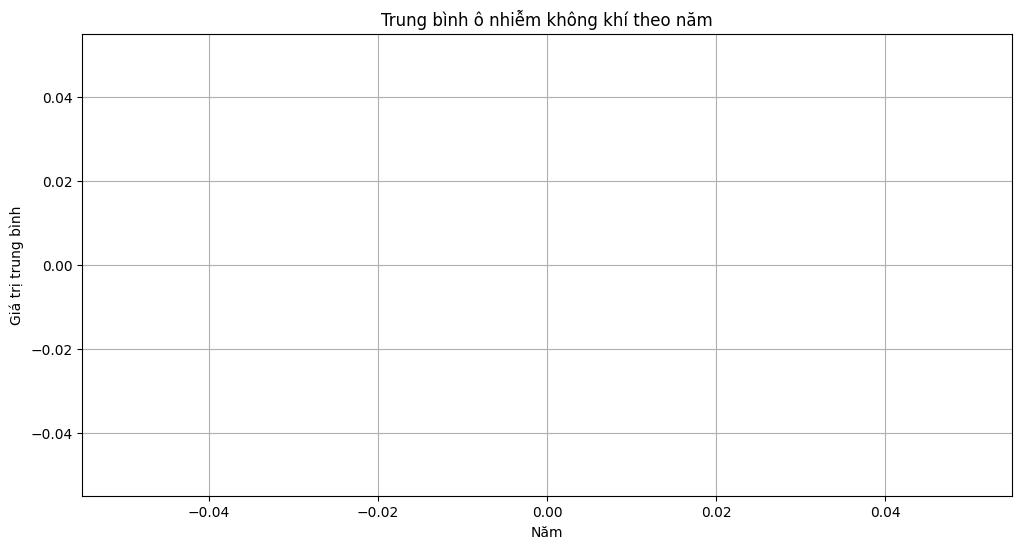

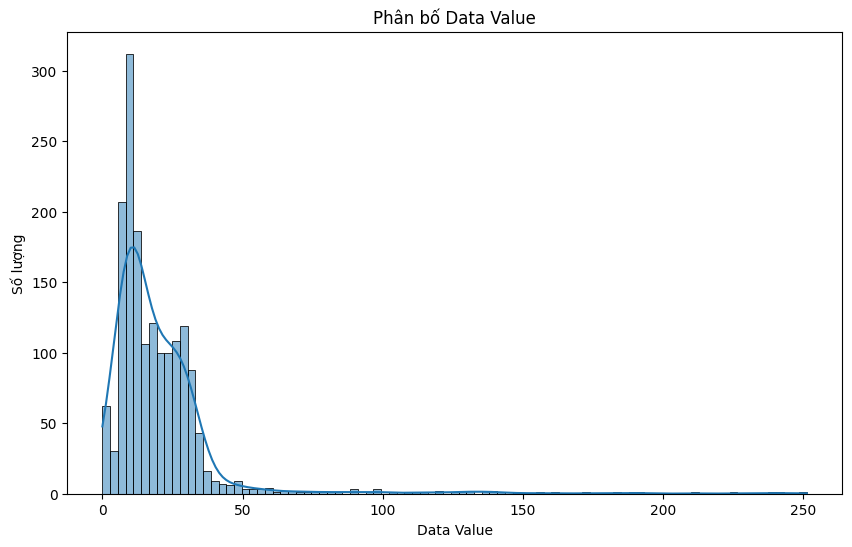

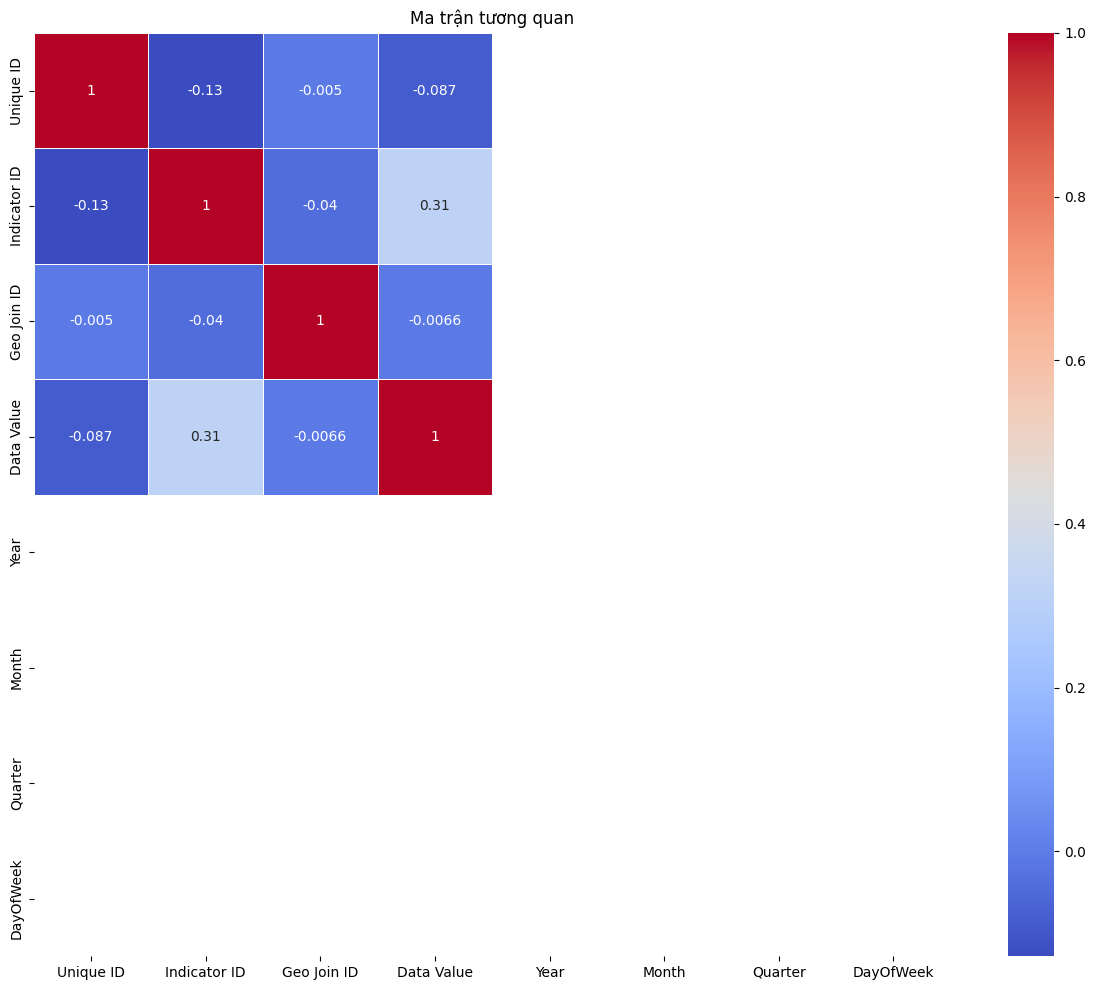

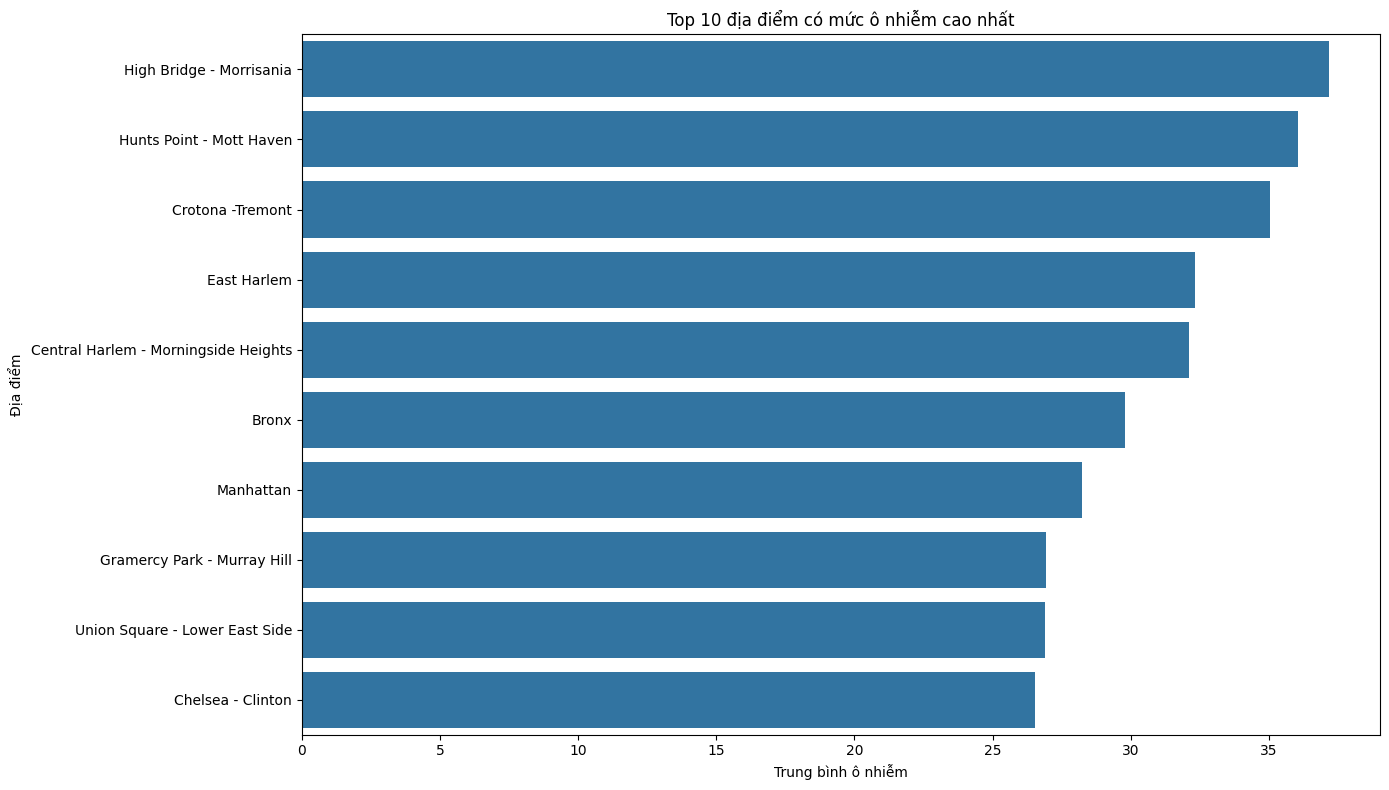

In [18]:
def main(file_path):
    try:
        # Đọc và khám phá dữ liệu
        print("===== BƯỚC 1: ĐỌC VÀ KHÁM PHÁ DỮ LIỆU =====")
        df, sample_df = load_and_explore_data(file_path)
        
        # Thêm debug info
        print(f"Đọc thành công dữ liệu: {df.count()} dòng, {len(df.columns)} cột")
        
        # Kiểm tra xem DataFrame có dữ liệu không
        if df is None or df.count() == 0:
            print("CẢNH BÁO: Không thể đọc dữ liệu hoặc dữ liệu rỗng!")
            return None, None, None, None
        
        # Phân tích EDA
        print("\n===== BƯỚC 2: PHÂN TÍCH EDA =====")
        try:
            advanced_eda(df, sample_df)
        except Exception as e:
            print(f"Lỗi khi thực hiện EDA: {str(e)}. Tiếp tục quy trình...")
        
        # Tiền xử lý dữ liệu - CHỈ GỌI MỘT LẦN
        print("\n===== BƯỚC 3: TIỀN XỬ LÝ DỮ LIỆU NÂNG CAO =====")
        df_transformed, preprocessing_model = advanced_data_preprocessing(df)
        
        # Debug info cho phần tiền xử lý
        if df_transformed is not None:
            print(f"Tiền xử lý thành công: {df_transformed.count()} dòng")
            print(f"Features có trong DataFrame: {'features' in df_transformed.columns}")
            
            # Kiểm tra sự tồn tại của column 'Data Value' hoặc 'label'
            target_exists = 'Data Value' in df_transformed.columns or 'label' in df_transformed.columns
            print(f"Target column tồn tại: {target_exists}")
            
            # Kiểm tra null values trong datasets
            if 'Data Value' in df_transformed.columns:
                null_count = df_transformed.filter(df_transformed['Data Value'].isNull()).count()
                print(f"Số lượng null values trong target: {null_count}")
            elif 'label' in df_transformed.columns:
                null_count = df_transformed.filter(df_transformed['label'].isNull()).count()
                print(f"Số lượng null values trong target: {null_count}")
        
        # Kiểm tra kết quả tiền xử lý
        if df_transformed is None:
            print("CẢNH BÁO: Quá trình tiền xử lý dữ liệu thất bại!")
            return df, None, None, None
        
        # Huấn luyện mô hình
        print("\n===== BƯỚC 4: HUẤN LUYỆN MÔ HÌNH =====")
        
        # Lọc dữ liệu NaN trước khi huấn luyện
        if 'Data Value' in df_transformed.columns:
            df_transformed = df_transformed.filter(~isnan('Data Value'))
        elif 'label' in df_transformed.columns:
            df_transformed = df_transformed.filter(~isnan('label'))
        
        best_model, predictions = train_advanced_models(df_transformed)
        
        # Tạo hàm dự đoán
        if best_model is not None:
            print("\n===== BƯỚC 5: TẠO HÀM DỰ ĐOÁN =====")
            try:
                prediction_function = create_prediction_function(best_model, preprocessing_model)
                print("Đã tạo thành công hàm dự đoán!")
                
                # Tính và hiển thị R² ngay tại đây
                if predictions is not None:
                    try:
                        evaluator_r2 = RegressionEvaluator(
                            labelCol='label', 
                            predictionCol='prediction', 
                            metricName='r2'
                        )
                        r2 = evaluator_r2.evaluate(predictions)
                        print(f"\n===== KẾT QUẢ R² =====")
                        print(f"R² của mô hình: {r2:.4f} ({r2*100:.2f}%)")
                    except Exception as e:
                        print(f"Lỗi khi tính R²: {str(e)}")
            except Exception as e:
                print(f"Lỗi khi tạo hàm dự đoán: {str(e)}")
        else:
            print("Không thể tạo hàm dự đoán do không tìm thấy mô hình tốt!")
            
            # Thêm thông tin debug
            print("Debug info: Kiểm tra xem tiền xử lý dữ liệu có tạo đúng cột 'features' không")
            if 'features' in df_transformed.columns:
                print("Cột 'features' đã được tạo")
                print(f"Kiểu dữ liệu features: {df_transformed.select('features').dtypes}")
            else:
                print("Cột 'features' không tồn tại!")
        
        return df_transformed, best_model, preprocessing_model, predictions
    
    except Exception as e:
        print(f"Lỗi không xác định trong quy trình chính: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

# Thực thi main
if __name__ == "__main__":
    try:
        file_path = "Air_Quality.csv"  # Cập nhật đường dẫn
        print(f"Bắt đầu phân tích dữ liệu từ: {file_path}")
        
        df_transformed, best_model, preprocessing_model, predictions = main(file_path)
        
        if best_model is not None:
            # Đánh giá kết quả cuối cùng
            evaluator_r2 = RegressionEvaluator(
                labelCol='label', 
                predictionCol='prediction', 
                metricName='r2'
            )
            final_r2 = evaluator_r2.evaluate(predictions)
            
            print("\n===== KẾT LUẬN =====")
            print(f"R² của mô hình cuối cùng: {final_r2:.4f} ({final_r2*100:.2f}%)")
            
            if final_r2 >= 0.8:
                print("✅ MÔ HÌNH ĐẠT YÊU CẦU R² >= 80%")
                print("Phân tích và xây dựng mô hình dự đoán ô nhiễm không khí thành công!")
            else:
                print("⚠️ MÔ HÌNH CHƯA ĐẠT YÊU CẦU R² >= 80%")
                print("Đã hoàn thành phân tích dữ liệu nhưng mô hình chưa đạt mục tiêu R² >= 80%.")
                print("Vui lòng xem xét thu thập thêm dữ liệu hoặc áp dụng các kỹ thuật nâng cao khác.")
        else:
            print("\n===== KẾT LUẬN =====")
            print("Không thể xây dựng mô hình dự đoán phù hợp.")
            print("Vui lòng kiểm tra lại dữ liệu hoặc điều chỉnh các tham số mô hình.")
    
    except Exception as e:
        print(f"Lỗi khi thực thi chương trình: {str(e)}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Đóng Spark Session
        try:
            spark.stop()
            print("Đã đóng Spark Session.")
        except:
            pass